# Ex 5 - Datacube for ML

This notebook briefly describes how to use the `Datacube` class for ML projects.
We will use small and non-representive datasets for the example. The aim is for you to be able to run the code and understand the core concept of integrating the datacube into your ML project.

In this example we will cover two main ML applications using the <a href='https://pytorch.org/'>Torch</a> framework:
   1. <b>Segmentation:</b> performs pixel-wise labeling with a set of object categories (for example, people, trees, sky, cars) for all image pixels.
    
   2. <b>Object classification:</b> refers to a collection of related tasks for identifying objects in digital photographs.
   
This example is dependent on installing `pytorch`, `xbatcher`.

In [85]:
from pathlib import Path
import os
import icecube
from icecube.bin.datacube import Datacube
from icecube.bin.generate_cube import IceyeProcessGenerateCube
import xbatcher
import torch
from torch.utils.data import Dataset
from torchvision import datasets
import xarray
import numpy as np
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.autograd import Variable

# Segmentation Example

In [86]:
# Read the datacube inputs
resource_dir = os.path.join(str(Path(icecube.__file__).parent.parent), "tests/resources")
grd_raster_dir = os.path.join(resource_dir, "grd_stack")
cube_config_fpath = os.path.join(resource_dir, "json_config/config_use_case5.json")
masks_labels_fpath = os.path.join(resource_dir, "labels/dummy_mask_labels.json")

#[
#    {
#        "product_file": "ICEYE_GRD_SLED_54549_20210427T215124_hollow_10x10pixels_fake_0.tif",
#        "labels": {
#            "segmentation": "/home/adupeyrat/Documents/code/icecube/tests/resources/masks/ICEYE_GRD_SLED_54549_20210427T215124_hollow_10x10pixels_fake_0.png"
#        }
#    },

In [87]:
dc = IceyeProcessGenerateCube.create_cube(grd_raster_dir, cube_config_fpath, masks_labels_fpath)

08/24/2021 12:28:50 PM - sar_datacube_metadata.py - [INFO] - Building the metadata from the folder /home/adupeyrat/Documents/code/icecube/tests/resources/grd_stack using GRD
processing rasters for cubes: 100%|██████████| 6/6 [00:00<00:00, 247.38it/s]
08/24/2021 12:28:50 PM - common_utils.py - [INFO] - create running time is 0.0603 seconds
08/24/2021 12:28:50 PM - sar_datacube_metadata.py - [INFO] - Building the metadata from the folder /home/adupeyrat/Documents/code/icecube/tests/resources/grd_stack using GRD
/home/adupeyrat/anaconda3/envs/icecube_env/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
processing rasters for labels cube: 100%|██████████| 6/6 [00:00<00:00, 683.33it/s]
08/24/2021 12:28:50 PM - common_utils.py - [INFO] - create running time is 0.0367 seconds


In [88]:
dc.xrdataset

<xarray.Dataset>
Dimensions:    (Azimuth: 10, Band: 6, Range: 10)
Coordinates:
  * Band       (Band) datetime64[ns] 2021-04-25 2021-04-26 ... 2021-04-30
  * Azimuth    (Azimuth) int64 0 1 2 3 4 5 6 7 8 9
  * Range      (Range) int64 0 1 2 3 4 5 6 7 8 9
Data variables:
    Intensity  (Band, Azimuth, Range) uint16 dask.array<chunksize=(1, 10, 10), meta=np.ndarray>
    Labels     (Band, Azimuth, Range) uint8 dask.array<chunksize=(1, 10, 10), meta=np.ndarray>

The dataset contains labels and data as `np.ndarray`. For the segmentation model we will create an IterableDataset that will be used to slice the datacube in 'Azimuth' and 'Range' direction. That way we can directly map it to a deep learning model.

In [89]:
class Iceye_GRD_Loader(torch.utils.data.IterableDataset):
    def __init__(self, list_xrdataset):
        super(Iceye_GRD_Loader).__init__()
        # Change the following for your application - For the purpose of te demo we are going to concat 
        # the same dataset along a new dimension, for a real project you are going to work with multiple stacks
        # For the example purpose we will work with path of size (6, 4, 4) using xbatcher to slice our
        # xarray dataset
        concated_dataset = xarray.concat(list_xrdataset, "stack")
        self.bgen = xbatcher.BatchGenerator(concated_dataset,
                                       {'stack': 1,
                                        'Band': 6,
                                        'Azimuth': 4,
                                        'Range': 4})
    def __iter__(self):
        for batch in self.bgen:
            # Tensorflow does not accept uint16 as type
            yield torch.from_numpy(np.squeeze(batch["Intensity"].values.astype("int32"), axis=None)), torch.from_numpy(np.squeeze(batch["Labels"].values, axis=None)).float()

In [90]:
training_data = Iceye_GRD_Loader([dc.xrdataset for i in range(10)])
# We select a batch size of 2.
train_dataloader = DataLoader(training_data, batch_size=2)

In [91]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))

In [92]:
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([2, 6, 4, 4])
Labels batch shape: torch.Size([2, 6, 4, 4])


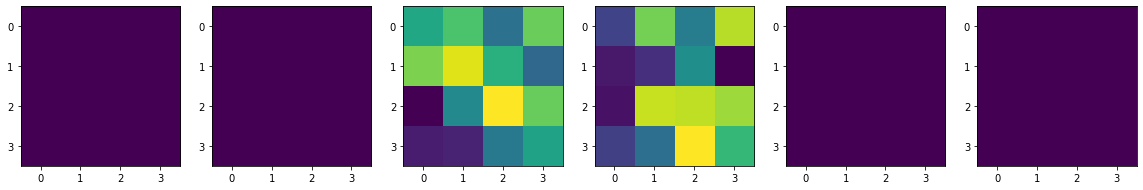

In [93]:
w = 20
h = 20
fig = plt.figure(figsize=(w, 8))
columns = 5
rows = 1
for i in range(0, columns*rows+1):
    img = train_features[0].squeeze()[i]
    fig.add_subplot(rows, columns+1, i+1)
    plt.imshow(img)
plt.show()

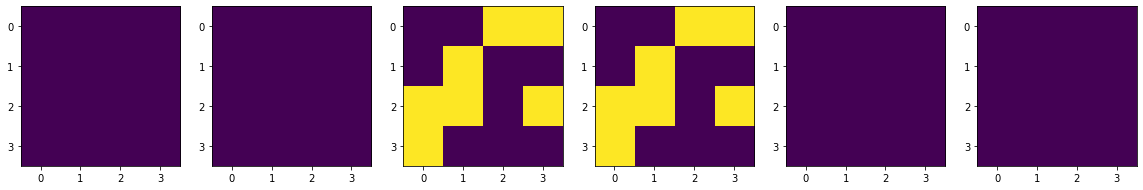

In [94]:
import numpy as np
import matplotlib.pyplot as plt

w = 20
h = 20
fig = plt.figure(figsize=(w, 8))
columns = 5
rows = 1
for i in range(0, columns*rows+1):
    img = train_labels[0].squeeze()[i]
    fig.add_subplot(rows, columns+1, i+1)
    plt.imshow(img)
plt.show()

In [95]:
import torch
from torch.nn import Module
from torch.nn import Sequential
from torch.nn import Conv2d, ReLU

# We build a mini model with tensorflow that will read our images and apply and 1d convolution
class MiniModel(Module):
    def __init__(self,):
        super(MiniModel, self).__init__()
        self.block1 = Sequential(
            Conv2d(6, 6, kernel_size=1, padding=0),
            ReLU()
        )

    def forward(self, x):
        return self.block1(x)

In [96]:
# Use gpu for training if available else use cpu
device = 'cpu'
# Here is the loss and optimizer definition
model = MiniModel()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

In [100]:
epochs = 50
for epoch in range(epochs):
    for i, (images, masks) in enumerate(train_dataloader, 1):
        images = images.to(device)
        masks = masks.type(torch.LongTensor)
        masks = masks.to(device)
        
        # Forward pass
        outputs = model(images.float())
       
        loss = criterion(outputs.float(), masks.float()).float()  
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.sum().backward()
        optimizer.step()
        
        if (i) % 20 == 0:
            print (f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.sum().item():4f}")

Epoch [1/50], Loss: 5351.588867
Epoch [2/50], Loss: 5354.871582
Epoch [3/50], Loss: 5358.108887
Epoch [4/50], Loss: 5361.300781
Epoch [5/50], Loss: 5364.446777
Epoch [6/50], Loss: 5367.545410
Epoch [7/50], Loss: 5370.596191
Epoch [8/50], Loss: 5373.599609
Epoch [9/50], Loss: 5376.554688
Epoch [10/50], Loss: 5379.460938
Epoch [11/50], Loss: 5382.316895
Epoch [12/50], Loss: 5385.125000
Epoch [13/50], Loss: 5387.882324
Epoch [14/50], Loss: 5390.589844
Epoch [15/50], Loss: 5393.247559
Epoch [16/50], Loss: 5395.854980
Epoch [17/50], Loss: 5398.412109
Epoch [18/50], Loss: 5400.919434
Epoch [19/50], Loss: 5403.376465
Epoch [20/50], Loss: 5405.783203
Epoch [21/50], Loss: 5408.140137
Epoch [22/50], Loss: 5410.447754
Epoch [23/50], Loss: 5412.705566
Epoch [24/50], Loss: 5414.914062
Epoch [25/50], Loss: 5417.073730
Epoch [26/50], Loss: 5419.184082
Epoch [27/50], Loss: 5421.246582
Epoch [28/50], Loss: 5423.261719
Epoch [29/50], Loss: 5425.228516
Epoch [30/50], Loss: 5427.148926
Epoch [31/50], Loss

Current model prediction


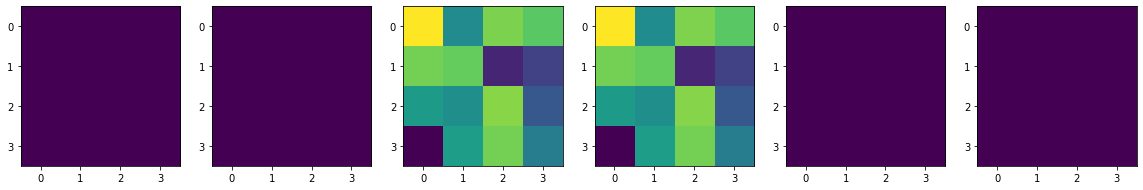

target prediction


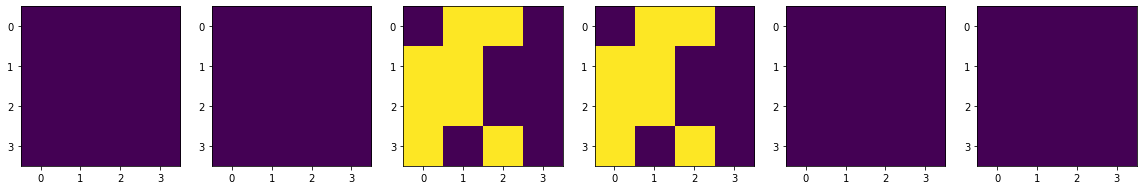

In [101]:
print("Current model prediction")
w = 20
h = 20
fig = plt.figure(figsize=(w, 8))
columns = 5
rows = 1
for i in range(0, columns*rows+1):
    output = outputs[0].squeeze()[i].detach().numpy()
    fig.add_subplot(rows, columns+1, i+1)
    plt.imshow(output)
plt.show()
            
print("target prediction")
w = 20
h = 20
fig = plt.figure(figsize=(w, 8))
columns = 5
rows = 1
for i in range(0, columns*rows+1):
    mask = masks[0].squeeze()[i].detach().numpy()
    fig.add_subplot(rows, columns+1, i+1)
    plt.imshow(mask)
plt.show()

hyvää työtä!